This tutorial will guide you through analyzing Shanghai Truck dataset with Arctern for massive Geospatial data processing and with keplergl for data visualization.


Load Shanghai truck trajectory data, the original data has a total of 8 columns, here only read the 4 columns required for analysis: plate number, time, latitude and longitude.

In [1]:
import pandas as pd
import arctern
from arctern import GeoSeries

sh_columns=[
    ("plate_number","string"),
    ("pos_time","string"),
    ("pos_longitude","double"),
    ("pos_latitude","double"),
    ("pos_direction0","double"),
    ("pos_direction1","double"),
    ("pos_direction2","double"),
    ("pos_direction3","double")
]

sh_select_columns={
                   "plate_number",
                   "pos_time",
                   "pos_longitude",
                   "pos_latitude"
                  }

sh_schema={}
sh_use_cols=[]
sh_names=[]
for idx in range(len(sh_columns)):
    if sh_columns[idx][0] in sh_select_columns:
        sh_schema[sh_columns[idx][0]] = sh_columns[idx][1]
        sh_use_cols.append(idx)
        sh_names.append(sh_columns[idx][0])
            
sh_df = pd.read_csv("/tmp/20181016.txt",
                    usecols=sh_use_cols,
                    names=sh_names,
                    dtype=sh_schema,
                    header=None,
                    delimiter="\t",
                    date_parser=pd.to_datetime,
                    parse_dates=["pos_time"])

According to the latitude and longitude, construct position information:

In [2]:
sh_df["pos_point"]=GeoSeries.point(sh_df.pos_longitude,sh_df.pos_latitude)
sh_df

,plate_number,pos_time,pos_longitude,pos_latitude,pos_point
0,沪DK7362,2018-10-16 00:00:00,121.273108,30.989863,POINT (121.273108 30.989863)
1,沪DT0830,2018-10-16 00:00:00,121.471555,31.121763,POINT (121.471555 31.121763)
2,沪EP2723,2018-10-16 00:00:00,121.717205,31.380190,POINT (121.717205 31.38019)
3,沪DH9100,2018-10-16 00:00:00,121.476368,31.197768,POINT (121.476368 31.197768)
4,沪DP8608,2018-10-16 00:00:00,121.826568,31.096545,POINT (121.826568 31.096545)
...,...,...,...,...,...
2076589,沪EG9666,2018-10-16 23:59:31,121.753138,31.356040,POINT (121.753138 31.35604)
2076590,沪DP8746,2018-10-16 23:59:35,121.447145,31.125255,POINT (121.447145 31.125255)
2076591,沪DP8746,2018-10-16 23:59:41,121.448203,31.125408,POINT (121.448203 31.125408)
2076592,沪DP8746,2018-10-16 23:59:48,121.449426,31.125510,POINT (121.449426 31.12551)


We can restore the running track of a truck. First, we select a plate numbers of truck and filter all the data:

In [3]:
one_trunck_plate_number=sh_df.plate_number[0]
print(one_trunck_plate_number)
one_truck_df = sh_df[sh_df.plate_number==one_trunck_plate_number]

沪DK7362


Draw all the track points of this car on the map:

In [4]:
from keplergl import KeplerGl
KeplerGl(data={"car_pos": pd.DataFrame(data={'car_pos':one_truck_df.pos_point.to_wkt()})})

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'car_pos':                               car_pos
0        POINT (121.273108 30.989863)
4922    …

Next, we will look at the running track of the above truck according to the road network information of Shanghai, and first load the road network information:

In [5]:
sh_roads=pd.read_csv("/tmp/sh_roads.csv", 
                     dtype={"roads":"string"},
                     usecols=[0],
                     names=["roads"],
                     header=None,
                     delimiter='|')
sh_roads=GeoSeries(sh_roads.roads)
sh_roads

0        LINESTRING (121.6358731 31.221484,121.6359771 ...
1        LINESTRING (121.6362516 31.2205594,121.6360422...
2        LINESTRING (121.6372043 31.220911,121.6369344 ...
3        LINESTRING (121.4637777 31.2314411,121.4637564...
4        LINESTRING (121.4628334 31.2311683,121.4627892...
                               ...                        
74688    LINESTRING (121.2544395 31.0235354,121.2550238...
74689    LINESTRING (121.6372338 31.2208457,121.6362516...
74690    LINESTRING (121.6372338 31.2208457,121.6373315...
74691    LINESTRING (121.3657763 31.085248,121.3656812 ...
74692    LINESTRING (121.6372043 31.220911,121.6372338 ...
Name: roads, Length: 74693, dtype: GeoDtype

Draw the above track location and road network information on the map:

In [6]:
one_truck_roads=KeplerGl(data={"car_pos": pd.DataFrame(data={'car_pos':one_truck_df.pos_point.to_wkt()})})
one_truck_roads.add_data(data=pd.DataFrame(data={'sh_roads':sh_roads.to_wkt()}),name="sh_roads")
one_truck_roads

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'car_pos':                               car_pos
0        POINT (121.273108 30.989863)
4922    …

With the visualized results on the map, by zooming it can be found in the track location of  that struck is not on the road, and these noisy data need to be cleared.

We think that the track location that are not on the road are noisy information, and these track points must be bound to the closest road:

In [7]:
is_near_road=arctern.near_road(sh_roads,sh_df.pos_point)
sh_near_road_df=sh_df[is_near_road]
on_road=arctern.nearest_location_on_road(sh_roads, sh_near_road_df.pos_point)
on_road=GeoSeries(on_road)
on_road

0          POINT (121.273065837839 30.9898629672054)
1          POINT (121.471521117758 31.1218966267949)
2          POINT (121.717183265368 31.3801593122801)
3           POINT (121.47636780833 31.1977688430427)
4          POINT (121.826533061028 31.0965194009541)
                             ...                    
2076589    POINT (121.753124012736 31.3560208068604)
2076590     POINT (121.44712530551 31.1255173541719)
2076591    POINT (121.448188797914 31.1255971887735)
2076592    POINT (121.449412558681 31.1256890544539)
2076593    POINT (121.880966206794 31.0821528456654)
Length: 1807018, dtype: GeoDtype

Bind the truck location to the road, and reconstruct the  `DataFrame`：

In [8]:
sh_on_road_df=pd.DataFrame(data={"plate_number":sh_near_road_df.plate_number,
                                 "pos_time":sh_near_road_df.pos_time,
                                 "on_road":on_road
                                })
sh_on_road_df

,plate_number,pos_time,on_road
0,沪DK7362,2018-10-16 00:00:00,POINT (121.273065837839 30.9898629672054)
1,沪DT0830,2018-10-16 00:00:00,POINT (121.471521117758 31.1218966267949)
2,沪EP2723,2018-10-16 00:00:00,POINT (121.717183265368 31.3801593122801)
3,沪DH9100,2018-10-16 00:00:00,POINT (121.47636780833 31.1977688430427)
4,沪DP8608,2018-10-16 00:00:00,POINT (121.826533061028 31.0965194009541)
...,...,...,...
2076589,沪EG9666,2018-10-16 23:59:31,POINT (121.753124012736 31.3560208068604)
2076590,沪DP8746,2018-10-16 23:59:35,POINT (121.44712530551 31.1255173541719)
2076591,沪DP8746,2018-10-16 23:59:41,POINT (121.448188797914 31.1255971887735)
2076592,沪DP8746,2018-10-16 23:59:48,POINT (121.449412558681 31.1256890544539)


Draw the track of the truck and the road network of Shanghai again:

In [9]:
one_on_road_df=sh_on_road_df[sh_on_road_df.plate_number==one_trunck_plate_number]
one_on_roads=KeplerGl(data={"car_pos": pd.DataFrame(data={'car_pos':one_on_road_df.on_road.to_wkt()})})
one_on_roads.add_data(data=pd.DataFrame(data={'sh_roads':sh_roads.to_wkt()}),name="sh_roads")
one_on_roads

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'car_pos':                                            car_pos
0        POINT (121.273065837839 …

By zooming, we can see that all the location are on the road.

We learned that there are 74,693 road network information records in Shanghai, but it is impossible for trucks to cross all roads. We will analyze the roads where trucks travel to see the roads with the highest frequency.

First filter out all the roads that the truck passes:

In [10]:
all_roads=arctern.nearest_road(sh_roads,sh_on_road_df.on_road)
all_roads=GeoSeries(all_roads)
road_codes, road_uniques = pd.factorize(all_roads)

Show the road data of all passing trucks and the percentage:

In [11]:
print(len(road_uniques))
print(len(road_uniques)*100.0/len(sh_roads))

16450
22.0234827895519


Draw all the roads that the truck passes:

In [12]:
KeplerGl(data={"all_roads": pd.DataFrame(data={'all_roads':GeoSeries(road_uniques).to_wkt()})})

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'all_roads':                                                all_roads
0      LINESTRING (121.27…

It can be seen that for some main roads, each truck will pass, resulting in more truch location on the road, and because this is a main road, the speed of the truck is slow, which further enhances the `GPS` data on the road.

Next, we will find for the busier road according to the number of truck location on the road.

Count the number of truck location on each road, and reconstruct `DataFrame`, we record the num of location point on the road as road weights:

In [13]:
roads_codes_series = pd.Series(road_codes)
roads_codes_series = roads_codes_series.value_counts()
roads_codes_series = roads_codes_series.sort_index()

sh_road_weight = pd.DataFrame(data={"on_road":GeoSeries(road_uniques),
                                    "weight_value":roads_codes_series
                                   })

sh_road_weight

,on_road,weight_value
0,"LINESTRING (121.2730666 30.9888831,121.2730596...",1646
1,"LINESTRING (121.4677565 31.1198416,121.4678423...",1579
2,"LINESTRING (121.7202751 31.3780202,121.7197339...",141
3,"LINESTRING (121.477849 31.1981056,121.4742212 ...",83
4,"LINESTRING (121.8374393 31.0816313,121.8345587...",1268
...,...,...
16445,"LINESTRING (121.4278848 31.2389835,121.4280869...",3
16446,"LINESTRING (121.431042 31.2403309,121.4307167 ...",1
16447,"LINESTRING (121.6378175 31.2374256,121.6373658...",1
16448,"LINESTRING (121.432118 31.2416392,121.4314564 ...",1


Show the road weights:

In [14]:
sh_road_weight.weight_value.describe()

count    16450.000000
mean       109.849119
std        802.067993
min          1.000000
25%          2.000000
50%          5.000000
75%         22.000000
max      28144.000000
Name: weight_value, dtype: float64

It can be found that most roads are not busy, but there are also some particularly busy roads.

Plot `weight_value` into a histogram, it can further confirm the previous conclusion:

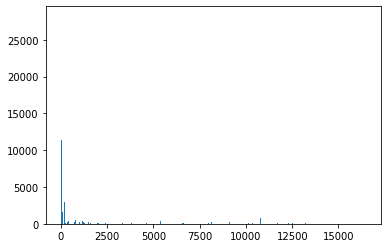

In [15]:
import matplotlib.pyplot as plt
plt.bar(sh_road_weight.index,sh_road_weight.weight_value)
plt.show()

Sort all roads according to road weights:

In [16]:
sh_sorted_road=sh_road_weight.sort_values(by=['weight_value'],ascending=False)
sh_sorted_road

,on_road,weight_value
102,"LINESTRING (121.4248121 31.4032657,121.4265065...",28144
23,"LINESTRING (121.473513 31.3702961,121.4736103 ...",24364
9,"LINESTRING (121.6349225 31.14309,121.6348039 3...",21448
43,"LINESTRING (121.2749664 31.0244814,121.2722674...",20599
89,"LINESTRING (121.3814009 31.391344,121.3820681 ...",20463
...,...,...
13661,"LINESTRING (121.3757469 31.0789625,121.3756868...",1
7980,"LINESTRING (121.3675949 31.2531523,121.3677313...",1
11360,"LINESTRING (121.6867871 31.104265,121.6815152 ...",1
13664,"LINESTRING (121.5174295 31.2760579,121.5171332...",1


Select the top 100 busiest roads:

In [17]:
sh_sorted_road.iloc[0:100]

,on_road,weight_value
102,"LINESTRING (121.4248121 31.4032657,121.4265065...",28144
23,"LINESTRING (121.473513 31.3702961,121.4736103 ...",24364
9,"LINESTRING (121.6349225 31.14309,121.6348039 3...",21448
43,"LINESTRING (121.2749664 31.0244814,121.2722674...",20599
89,"LINESTRING (121.3814009 31.391344,121.3820681 ...",20463
...,...,...
13,"LINESTRING (121.4986731 31.2685444,121.4963124...",3668
566,"LINESTRING (121.3656233 31.257495,121.3689789 ...",3655
291,"LINESTRING (121.5675539 31.3573854,121.5650207...",3625
759,"LINESTRING (121.4644001 31.3612873,121.463751 ...",3622


Draw the busiest first 100 roads on the map:

In [18]:
KeplerGl(data={"on_roads": pd.DataFrame(data={'on_roads':sh_sorted_road.on_road.iloc[0:100].to_wkt()})})

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'on_roads':                                               on_roads
102  LINESTRING (121.4248121…